# Load Combinations
*Pystra* includes the class `LoadCombination` which can be used to analyse a structural reliability problem for different load cases. This example demonstrates the use of load combination cases with *Pystra*.

## Example
This demonstration problem is adopted from Example 4 pp 190-1 from Sorensen, J.D. (2004), *Notes in Structural Reliability Theory And Risk Analysis*. The parameter values are slightly modified for demonstration.

### Import Libraries

In [1]:
import pystra as ra
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Define the limit state function
The LSF to be supplied in `LoadCombination` can be any valid *Pystra* LSF. Here we show how random variables and even constants (e.g. `cg`) can be passed through as *Pystra* objects, or can be hard-coded into the LSF.

In [2]:
def lsf(R, G, Q1, Q2, cg):
    return R - (cg*G + 0.8*Q1 + 0.2*Q2)

### Define the Load and Resistance distributions
We define the distributions of the loads for the load combinations. Some loads will be time-invariant (e.g. permanent loads), while some will be combination random variables (e.g. winds, imposed loads). These combination loads require the definition of a point-in-time (`'pit'`) distribution and a maximum (`'max'`) distribtribution (typically annual maximum). Note that *Pystra* has built in distribution objects to convert between the two: `MaxParent` and `Maximum`.

For the combination loads, we define a dictionary which contains a key for each variable in the LSF, and a dictionary with the `pit` and `max` key values being the corresponding *Pystra* distribution objects.

Define the annual max distributions

In [3]:
Q1max = ra.Gumbel("Q1", 1, 0.2)  # Imposed Load
Q2max = ra.Gumbel("Q2", 1, 0.4)  # Wind Load

Next specifcy the parameters of inferred point-in-time parent distributions

In [4]:
Q1pit = ra.Gumbel("Q1", 0.89, 0.2)  # Imposed Load
Q2pit = ra.Gumbel("Q2", 0.77, 0.4)  # Wind Load
Q_dict = {'Q1': {'max': Q1max, 'pit': Q1pit}, 
          'Q2': {'max': Q2max, 'pit': Q2pit}}

And define any constants to be passed through

In [5]:
cg = ra.Constant("cg", 0.4)

Finally, define any other random variables in the problem

In [6]:
Rdist = ra.Lognormal("R", 2.0, 0.15)  # Resistance
Gdist = ra.Normal("G", 1, 0.1)  # Permanent Load (Other load variable)

### Specify load combination cases
For this problem, in addition to the permanent loads, we're interested in investigating the reliabilities for several load combinations:
1. `Q1Q2_max`: Where both `Q1` and `Q2` maximum distributions are considered simultaneously, as an obvious conservative estimation.
2. `Q1_max`: `Q1` is maximum and  `Q2` is the point-in-time distribution.
3. `Q2_max`: `Q1` is the point-in-time distribution and  `Q2` is maximum.

We define a dictionary with the relevant loadcase names and corresponding variable names form the LSF.

In [7]:
loadcombinations = {'Q1Q2_max':['Q1', 'Q2'], 'Q1_max':['Q1'], 'Q2_max':['Q2']}

**Note**: The specification of this dictionary is optional. By default, `LoadCombination` assumes one combination load to act at its maximum in a load case, while the others are considered to be the point-in-time distribution.

### Specify user-defined correlation (optional)
The user can also specify a user-defined correlation matrix for the random variables of the reliability problem as a DataFrame.

In [8]:
label_rvs = ["Q1", "Q2", "R", "G"]
corr = np.eye(len(label_rvs))
df_corr = pd.DataFrame(data=corr, columns=label_rvs, index=label_rvs)
corr_Q1Q2 = 0.8
df_corr.loc["Q1", "Q2"] = corr_Q1Q2
df_corr.loc["Q2", "Q1"] = corr_Q1Q2
print(df_corr)

     Q1   Q2    R    G
Q1  1.0  0.8  0.0  0.0
Q2  0.8  1.0  0.0  0.0
R   0.0  0.0  1.0  0.0
G   0.0  0.0  0.0  1.0


### Specify user-defined analysis options (optional)
The user can also specify a user-defined correlation Pystra `AnalysisOptions` object for the reliability analysis too. In this tutorial we will set error thresholds and change the default transform method to use singular value decomposition.

In [9]:
options = ra.AnalysisOptions()
options.setE1(1e-3)
options.setE2(1e-3)
options.setTransform("svd")

### Instantiate `LoadCombination` object
`LoadCombination` class requires specification of combination distributions as a dictionary, while the other distributions (permanent loads and resistances) are specified as a list.

In [10]:
lc = ra.LoadCombination(lsf=lsf, dict_dist_comb=Q_dict, list_dist_resist=[Rdist], list_dist_other=[Gdist],
                        corr=df_corr, list_const=[cg], opt=options, dict_comb_cases=loadcombinations)

### Analyse Load Cases

Use a list to keep track of each `Form` object outputted:

In [11]:
form = 3*[None]

#### Load Case 1

In [12]:
lc_idx = 0
form[lc_idx] = lc.run_reliability_case(lcn='Q1Q2_max')
form[lc_idx].showDetailedOutput()


FORM
Pf              	 2.5348733315e-02
BetaHL          	 1.9540317148
Model Evaluations 	 38
------------------------------------------------------
Variable   	    U_star 	       X_star 	     alpha
R          	 -1.818038 	     1.898248 	 -0.930293
G          	 -0.659741 	     1.018495 	 -0.337834
Q1         	  0.184954 	     1.423639 	 +0.095051
Q2         	 -0.208597 	     1.759687 	 -0.106715
cg         	       --- 	     0.400000 	       ---



#### Load Case 2

In [13]:
lc_idx = 1
form[lc_idx] = lc.run_reliability_case(lcn='Q1_max')
form[lc_idx].showDetailedOutput()


FORM
Pf              	 1.9624337657e-02
BetaHL          	 2.0615701821
Model Evaluations 	 49
------------------------------------------------------
Variable   	    U_star 	       X_star 	     alpha
R          	 -1.926554 	     1.896315 	 -0.934503
G          	 -0.673345 	     1.018964 	 -0.326631
Q1         	  0.189636 	     1.461699 	 +0.091993
Q2         	 -0.221604 	     1.596853 	 -0.107490
cg         	       --- 	     0.400000 	       ---



#### Load Case 3

In [14]:
lc_idx = 2
form[lc_idx] = lc.run_reliability_case(lcn='Q2_max')
form[lc_idx].showDetailedOutput()


FORM
Pf              	 1.5511691106e-02
BetaHL          	 2.1567726618
Model Evaluations 	 49
------------------------------------------------------
Variable   	    U_star 	       X_star 	     alpha
R          	 -2.022994 	     1.894827 	 -0.937968
G          	 -0.683828 	     1.019274 	 -0.317075
Q1         	  0.192740 	     1.386755 	 +0.089372
Q2         	 -0.233228 	     1.888565 	 -0.108134
cg         	       --- 	     0.400000 	       ---



#### Display reliability per load combination

In [15]:
for lc,β in zip([k for k in loadcombinations.keys()], [f.beta for f in form]):
    print(f"{lc}: β = {β[0]:.2f}")

Q1Q2_max: β = 1.95
Q1_max: β = 2.06
Q2_max: β = 2.16


## Distributions for Load Combinations

`Pystra` includes a range of tools to enable the calculation of load combinations due to variable loads:

- **Zero-Inflated** Distributions allow for a probability of non-occurence of a load
- **Maximum** Distributions allow the distribution of maxima of a supplied parent or point-in-time distribution
- **MaxParent** Distribution allows the determination of the point-in-time distribution from a supplied maximum.

### Zero-Inflated Distribution

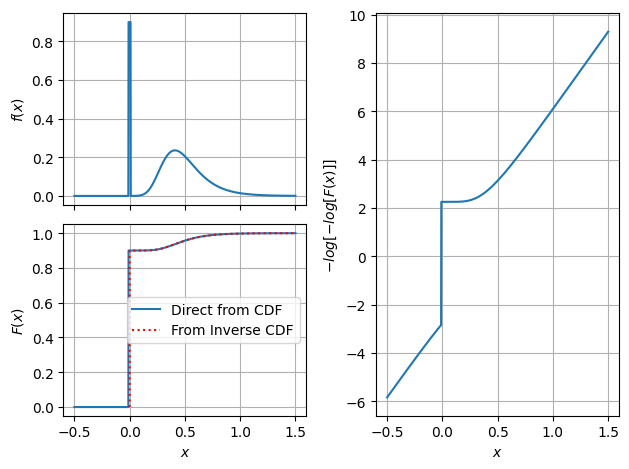

In [16]:
zin = ra.ZeroInflated('Q',ra.Gumbel("G", 0.5, 0.2),p=0.9)
zin.zero_tol = 1e-2
x = np.linspace(-0.5,1.5,1000)
pdf = zin.pdf(x)
cdf = zin.cdf(x)
u = np.linspace(0,1,10001)
ppf = zin.ppf(u)
fig,axs = plt.subplot_mosaic([['a','c'],['b','c']],sharex=True)
ax = axs['a']
ax.plot(x,pdf)
ax.set_ylabel('$f(x)$')
ax.grid()
ax = axs['b']
ax.plot(x,cdf,label='Direct from CDF')
ax.plot(ppf,u,'r:',label='From Inverse CDF')
ax.set_ylabel('$F(x)$')
ax.set_xlabel('$x$')
ax.legend(loc='center right')
ax.grid()
ax = axs['c']
ax.plot(x,-np.log(-np.log(cdf)))
ax.set_ylabel('$-log[-log[F(x)]]$')
ax.set_xlabel('$x$')
ax.grid()
plt.tight_layout();
#fig.set_layout('tight');

### Example

In [17]:
def lsf(R,G,Q):
    return R - (G + Q)

In [18]:
def reliability(p=0.0):
    ls = ra.LimitState(lsf)
    sm = ra.StochasticModel()
    sm.addVariable(ra.Lognormal("R", 6.0,0.15))
    sm.addVariable(ra.Normal("G", 4.5, 0.2))
    
    g = ra.Gumbel("Q", 0.5, 0.2)
    if p == 1.0:
        sm.addVariable(ra.Constant("Q",0.0))
    elif p == 0.0:
        sm.addVariable(g)
    else:
        zig = ra.ZeroInflated("Q",g,p=p)
        sm.addVariable(zig)
    
    form = ra.Form(sm,ls)
    form.run()
    
    return form

In [19]:
betas = []
ps = np.linspace(0,1.0,101)
for p in ps:
    form = reliability(p=p)
    betas.append(form.beta)

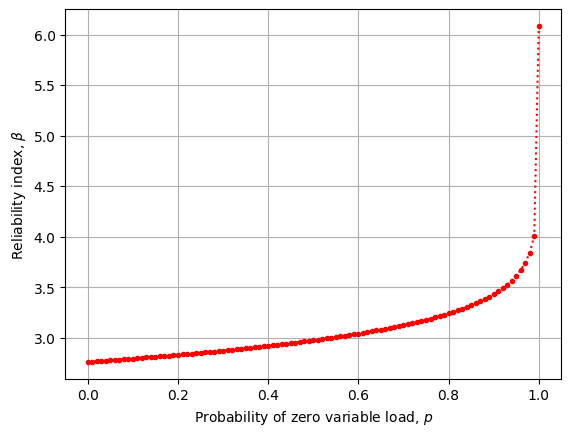

In [20]:
fig,ax = plt.subplots()
ax.plot(ps,betas,'r.:')
ax.set_xlabel('Probability of zero variable load, $p$')
ax.set_ylabel('Reliability index, $β$')
ax.grid();